In [ ]:
#export
import math
import numpy as np
from sklearn.cluster import MeanShift
import skimage
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.draw import circle_perimeter
from scipy import ndimage, signal
from scipy.ndimage.filters import convolve

from typing import Tuple
import matplotlib.pyplot as plt
from imageio import imread, imsave

def compute_gradients(img):
    gx = gy = np.zeros_like(img)

    dx = [[1, 0, -1],[ 1, 0, -1], [1, 0, -1]]
    dy = [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
    
    # needs to be switched to convolve to work on egg. Im about to die I cant do this anymore
    gx = ndimage.convolve(img, dx, mode='constant', cval=0.0)
    gy = ndimage.convolve(img, dy, mode='constant', cval=0.0)
  
    return gx, gy


# centers = detect_circles(img, radius, use_gradient) - Given an RGB image img, a target
# radius that specifies the size of circle we are looking for, and a flag use_gradient that allows the user
# to optionally exploit the gradient direction measured at the edge points. The output centers is an N x
# 2 matrix in which each row lists the (x, y) position of a detected circles’ center. Save this function
# in a file called submissionDetectCircles.py and submit it.

h_sigma = 2
h_low_threshold = 0.2
h_vote_percent = 0.50

def detect_circles(img : np.ndarray, radius : int, use_gradient : bool):
    
    if img.ndim > 2:
        img = rgb2gray(img)
    
    edges = canny(img, sigma = h_sigma, low_threshold = h_low_threshold)
    
    gradient_dir = np.zeros_like(img)
    if use_gradient:
        gx, gy = compute_gradients(img)
        gx[gx == 0] = .00000001 # To avoid possible divide by zeros
        gradient_direction = np.arctan(gy/gx)
    
    accumulator = np.zeros(img.shape,dtype='int')

    rows, columns = edges.shape
    accumulator = np.zeros((rows, columns))
    for row in range(0, rows):
        for column in range(0, columns):
            if edges[row, column] == True:
                if use_gradient:
                    theta = gradient_direction[row, column]
                    a = int(round(row + radius * math.sin(theta)))
                    b = int(round(column + radius * math.cos(theta)))
                    # if in image. vote
                    if a >= 0 and a < accumulator.shape[0] and b >= 0 and b < accumulator.shape[1]:
                        accumulator[a, b] += 1
                    theta = gradient_direction[row, column] - math.pi
                    a = int(round(row + radius * math.sin(theta)))
                    b = int(round(column + radius * math.cos(theta)))
                    # if in image. vote
                    if a >= 0 and a < accumulator.shape[0] and b >= 0 and b < accumulator.shape[1]:
                        accumulator[a, b] += 1
                else:
                    for theta in np.arange(0, 2 * math.pi, .01):
                        a = int(round(row + radius * math.sin(theta)))
                        b = int(round(column + radius * math.cos(theta)))
                        # if in image. vote
                        if a >= 0 and a < accumulator.shape[0] and b >= 0 and b < accumulator.shape[1]:
                            accumulator[a, b] += 1
    
    vote_threshold = int(round(np.max(accumulator) * h_vote_percent))

    results_a, results_b = (np.where(accumulator >= vote_threshold))
    cartesian_results = np.stack((results_b, results_a), axis=1)
    
#     clustering = MeanShift(bandwidth=2).fit(cartesian_results)
#     cartesian_results = clustering.cluster_centers_
   

    # visualize results
#     print("Original points cluster assignments: \n" + str(clustering.labels_))
#     print("Cluster centers: \n" + str(cartesian_results))
    print("Circle Results: \n" + str(cartesian_results))

    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20.0, 10.0))
    fig.suptitle("Egg Circle Detection \n sigma = " + str(h_sigma) + " \n use_gradient = " + str(use_gradient) + "\n radius = " + str(radius) 
                 + " \nNumber of results: " + str(cartesian_results.shape[0]), wrap=True, fontsize=14)
    ax1.set_title("Edge Detection")
    ax2.set_title("Accumulator Array \n (Vote Space)", wrap=True, fontsize=14)
    ax3.set_title("Detected Circles", fontsize=14)
    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax1.imshow(edges, interpolation='none', aspect='1')
    ax2.imshow(accumulator, cmap='gray', interpolation='none', aspect='1')     # ax2 is vote space      
    ax3.imshow(edges, interpolation='none', aspect='1')
   
    for i in range(cartesian_results.shape[0]):
        circle = plt.Circle(cartesian_results[i], radius, color='g', clip_on=True)
        ax3.add_artist(circle)
    
    return cartesian_results

                        
    

Circle Results: 
[[ 81   6]
 [ 80   7]
 [ 50  40]
 [ 51  40]
 [127  40]
 [128  40]
 [ 51  41]
 [ 79  63]
 [ 78  64]
 [ 79  64]
 [145  87]
 [ 39  91]
 [ 62  92]
 [ 61  93]
 [ 62  93]
 [ 77 104]
 [ 98 114]
 [ 98 115]
 [ 39 117]
 [ 40 117]
 [ 40 118]
 [ 32 123]
 [120 152]
 [121 152]
 [120 153]
 [121 153]
 [ 70 160]
 [ 70 161]]


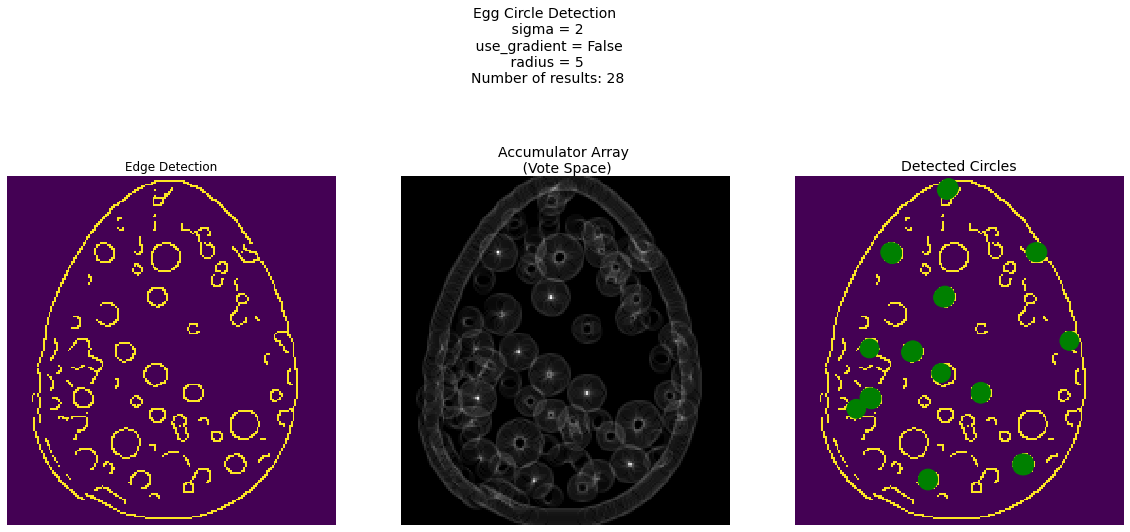

In [ ]:
test_img = imread("./egg.jpg")

test_radius = 5

circles = detect_circles(test_img, test_radius, False)

